In [1]:
import tensorflow as tf
from tensorflow import keras

#Usaremos datetime para nombrar archivos
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import requests
from io import BytesIO

#verficamos la version de tensorflow tf 2.0
print(tf.__version__)

from sklearn.model_selection import train_test_split

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

from sklearn import metrics
from sklearn.metrics import roc_auc_score


2.15.0


In [2]:
diabetes = pd.read_csv("/content/diabetes.csv")

diabetes.info()
# Hay 9 columnas completas, no hay valores nulos o faltantes, y las variables son de tipo numéricas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
diabetes.describe(percentiles=[0.25,0.75,0.90])
# El máximo de embarazos es 17, podría considerarse un outlier, pensando si es posible que una persona tenga 17 embarazos ?
# El mínimo 0 de glucosa y presión sanguinea también podría considerarse outlier, teniendo en cuenta que al 25% de los datos hay un salto más grande
# La variable insulina tiene una desviación estándar elevada, por lo que no tenemos datos homogéneos, y por otro lado, el valor máximo de esta variable tiene un gran salto respecto del 90% de la data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
90%,9.000000,167.000000,88.000000,40.000000,210.000000,41.500000,0.878600,51.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


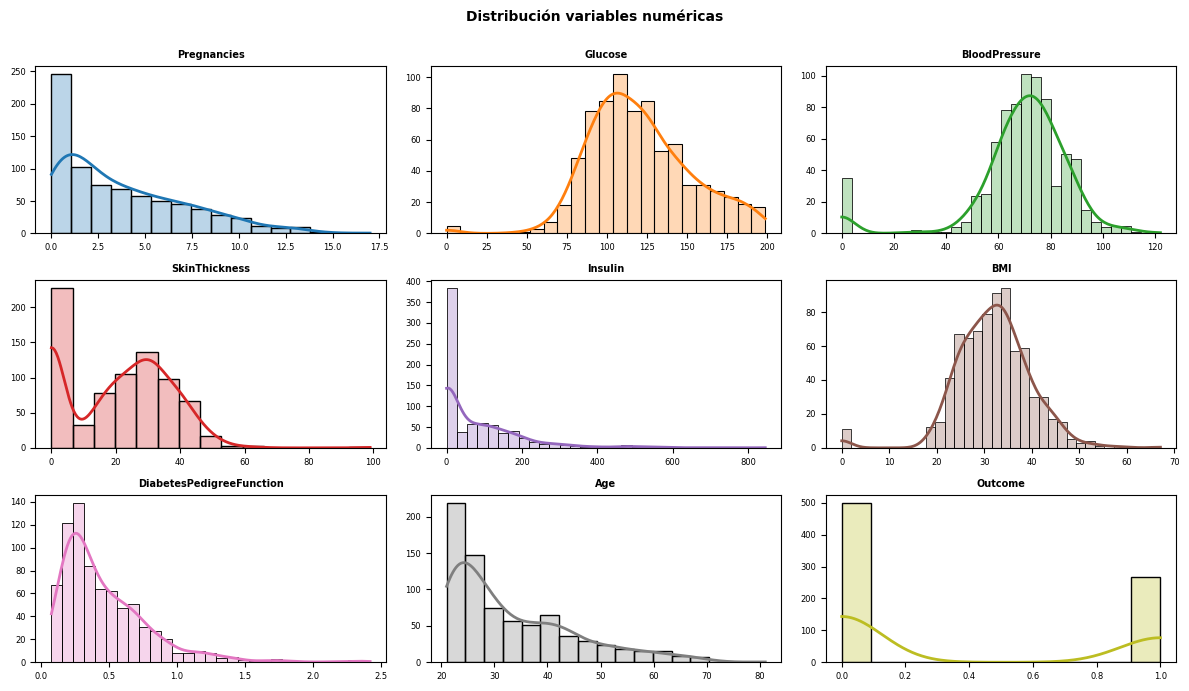

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))
axes = axes.flat

for i, colum in enumerate(diabetes.columns):
    sns.histplot(
        data    = diabetes,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

# De la distribución de nuestros datos podemos ver que solo tres variables, glucosa, presion sanguinea y BMI podrían considerarse normales,
# habría que realizar un test de normalidad y/o bien eliminar datos atípicos para corregir outliers y que queden normalizados

In [5]:
target_column = diabetes['Outcome']
predictors = list(set(list(diabetes.columns))-set(target_column)) # set() Los elementos repetidos de la lista se eliminan
diabetes[predictors] = diabetes[predictors]/diabetes[predictors].max() #Normalización

diabetes[predictors]

#Outcome 1 --> tiene diabetes
#Outcome 0 --> no tiene diabetes

,SkinThickness,BMI,DiabetesPedigreeFunction,Insulin,Glucose,Age,BloodPressure,Outcome,Pregnancies
0,0.353535,0.500745,0.259091,0.000000,0.743719,0.617284,0.590164,1.0,0.352941
1,0.292929,0.396423,0.145041,0.000000,0.427136,0.382716,0.540984,0.0,0.058824
2,0.000000,0.347243,0.277686,0.000000,0.919598,0.395062,0.524590,1.0,0.470588
3,0.232323,0.418778,0.069008,0.111111,0.447236,0.259259,0.540984,0.0,0.058824
4,0.353535,0.642325,0.945455,0.198582,0.688442,0.407407,0.327869,1.0,0.000000
...,...,...,...,...,...,...,...,...,...
763,0.484848,0.490313,0.070661,0.212766,0.507538,0.777778,0.622951,0.0,0.588235
764,0.272727,0.548435,0.140496,0.000000,0.613065,0.333333,0.573770,0.0,0.117647
765,0.232323,0.390462,0.101240,0.132388,0.608040,0.370370,0.590164,0.0,0.294118
766,0.000000,0.448584,0.144215,0.000000,0.633166,0.580247,0.491803,1.0,0.058824


In [6]:
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.259091,0.617284,1.0
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.145041,0.382716,0.0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.277686,0.395062,1.0
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.069008,0.259259,0.0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.945455,0.407407,1.0
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.070661,0.777778,0.0
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.140496,0.333333,0.0
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.101240,0.370370,0.0
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.144215,0.580247,1.0


In [7]:
X = diabetes.drop('Outcome', axis=1).values
y = diabetes['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2024)

In [8]:
# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

count_classes = y_test.shape[1]
count_classes

2

In [9]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [10]:
seed = 7
np.random.seed(seed)
model = Sequential()  # constructor secuencial
model.add(Dense(250, activation='relu', input_dim=8)) # capa de entrada y el número de dimensiones de entrada. input: nuestro caso son 8 predictores
model.add(Dense(50, activation='relu')) # función de activación
model.add(Dense(2, activation='sigmoid')) # capa de salida con dos nodos

# ReLU es la función de activación más utilizada porque no es lineal y tiene la
# capacidad de no activar todas las neuronas al mismo tiempo.


# Compilando el modelo
model.compile(optimizer='adam', # algoritmo optimizador #  La principal ventaja del optimizador "adam" es que no necesitamos especificar la tasa de aprendizaje y optimia la tasa de aprendizaje
              loss='categorical_crossentropy', # 'entropía cruzada categórica'
              metrics=['accuracy'])

In [11]:
# build the model

model.fit(X_train, y_train, epochs=150, verbose = False) # epochs: es el número de iteraciones de entrenamiento.

In [12]:
pred_train= model.predict(X_train) # Predicción del entrenamiento
scores = model.evaluate(X_train, y_train, verbose=0) # Predicción del modelo
print('Accuracy con la data train: {}% \n El error de la data de entrenamiento es: {}'.format(scores[1], 1 - scores[1]))

pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy con la data test: {}% \n El error de la data de testeo es: {}'.format(scores2[1], 1 - scores2[1]))

18/18 [==============================] - 0s 2ms/step
Accuracy con la data train: 0.8576388955116272% 
 El error de la data de entrenamiento es: 0.1423611044883728
6/6 [==============================] - 0s 3ms/step
Accuracy con la data test: 0.7552083134651184% 
 El error de la data de testeo es: 0.2447916865348816


18/18 [==============================] - 0s 2ms/step
Accuracy con la data train: 0.8697916865348816%
 El error de la data de entrenamiento es: 0.1302083134651184
6/6 [==============================] - 0s 3ms/step
Accuracy con la data test: 0.78125%
 El error de la data de testeo es: 0.21875

In [13]:
pred_test[:5]

array([[0.33723408, 0.6269564 ],
       [0.7977117 , 0.20377201],
       [0.851407  , 0.12136406],
       [0.52017593, 0.4749548 ],
       [0.8809403 , 0.13606101]], dtype=float32)

In [14]:
# Validando el modelo
from sklearn.metrics import classification_report, confusion_matrix

pred_test =np.argmax(pred_test, axis=1)
y_test=np.argmax(y_test, axis=1)

confusion = confusion_matrix(y_test, pred_test)
display(confusion)
print(' ')

print(classification_report(y_test, pred_test))
# De acuerdo a la matriz de confusion el modelo predice bien los verdaderos negativos y verdaderos positivos, sin embargo hay un alto numero de falsos positivos
# La precision para diabetes es 81% y el modelo tiene un accuracy de 77%

array([[116,   7],
       [ 40,  29]])

 
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       123
           1       0.81      0.42      0.55        69

    accuracy                           0.76       192
   macro avg       0.77      0.68      0.69       192
weighted avg       0.77      0.76      0.73       192



In [15]:
roc_auc = roc_auc_score(y_test, pred_test)
print('Curva ROC - AUC del modelo:')
print(roc_auc)
# Podría haber mejor valor para AUC, ya que mientras más cercano a 1, el modelo se ajusta mejor a nuestros datos, pero este fue el máximo valor que obtuve de todas las iteraciones que hice
# Predice mejor 0 que 1 en cuanto a diabetes

Curva ROC - AUC del modelo:
0.6816896429833864


Curva ROC - AUC del modelo:
0.7306468716861082

